# Signals Analysis

In [114]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import matplotlib_venn
import networkx as nx
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set_context('notebook')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
workingDirectory = '/home/jtao/analysis/signals_analysis/'
os.chdir(workingDirectory)

## Functions

In [107]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    return sequence_array_list




In [108]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list



In [109]:
def read_motif_file(motifPath, pseudocount):
    '''
    reads all motif files in a directory 
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores = scores + pseudocount
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

## Identify Acessible Promoters

In [118]:
! mergePeaks -d given -venn venn.txt ./resized_peak_files/c57bl6_kla-1h_peaks.tsv ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv ./resized_peak_files/c57bl6_veh_peaks.tsv > ./merged_atac_veh_ifng_kla_peaks.tsv

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (31867 total) and ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (31867 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (31867 total) and ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv (28784 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (31867 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (32540 total)
	Comparing ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv (28784 total) and ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (31867 total)
	Comparing ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv (28784 total) and ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv (28784 total)
	Comparing ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv (28784 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (32540 total)
	Comparing ./resized_peak_files/c57bl6_veh_peaks.tsv (32540 total) and ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (31867 to

In [3]:
# resize peaks
merged_frame = pd.read_csv('./merged_atac_veh_ifng_kla_peaks.tsv', sep='\t')
merged_frame.index = merged_frame.ix[:,0].values

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 500
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_atac_veh_ifng_kla_resized_peaks.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [120]:
! annotatePeaks.pl ./merged_atac_veh_ifng_kla_resized_peaks.tsv mm10 -d ./tag_directories_atac/*KLA* ./tag_directories_atac/*IFNg* ./tag_directories_atac/*Veh* > ./annotated_atac_veh_ifng_kla_peaks.tsv


	Peak file = ./merged_atac_veh_ifng_kla_resized_peaks.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 45826
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 45826
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:............

In [4]:
# read in annotated frame
annotated_frame = pd.read_csv('./annotated_atac_veh_ifng_kla_peaks.tsv', sep='\t')
annotated_frame.index = annotated_frame.ix[:,0].values

# get promoter associated peaks and associated gene names
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].ix[:,0].values
annotated_promoter_frame = annotated_frame[annotated_frame.index.isin(promoter_ids)]


columns = list(annotated_promoter_frame.columns.values)
columns = columns[:4] + [x for x in columns[1:] if 'Tag Count' in x]

annotated_promoter_frame =annotated_promoter_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-1].split(' ')[0] if '/' in x else x for x in columns]
annotated_promoter_frame.columns = columns
treatments = set([x.split('_')[3] for x in annotated_promoter_frame.columns if '_' in x])

for treatment in treatments:
    treatment_cols = [x for x in columns if treatment in x]
    annotated_promoter_frame[treatment] = annotated_promoter_frame[treatment_cols].mean(axis=1)
    for t in treatment_cols:
        del annotated_promoter_frame[t]
# # annotated_promoter_frame

In [5]:

id_gene_dict = dict(zip(promoter_ids, annotated_frame.ix[promoter_ids,'Gene Name'].values))

filtered_frame = filtered_frame[filtered_frame.index.isin(promoter_ids)]

filtered_frame.to_csv('./merged_atac_peaks_promoters.tsv', sep='\t', index=False)

In [123]:
! makeSummaryFile.py ./merged_atac_peaks_promoters.tsv ./group_atac_promoter_summary.tsv ./resized_peak_files/c57bl6_kla-1h_peaks.tsv ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv ./resized_peak_files/c57bl6_veh_peaks.tsv

Finished reading merged peak file...
Integrating scores for c57bl6_kla-1h
Integrating scores for c57bl6_ifng-1h
Integrating scores for c57bl6_veh


In [6]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_promoter_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values


## Calculate Motif Scores

In [125]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_atac_peaks_promoters.tsv > ./tmp
tail -n +2 ./tmp > ./merged_atac_peaks_promoters.bed
rm tmp


	Converted 9553 peaks total



In [126]:
!/gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py ./merged_atac_peaks_promoters.bed mm10 ./merged_atac_peaks_promoters.fasta

reading genome mm10


In [ ]:
# calculate motif scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_all_motif_scores.py -num_procs 50 ./merged_atac_peaks_promoters.fasta ./motif_scores_promoters /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat/*motif 

arntl_mitf calculation time: 341.81499791145325
bhlh calculation time: 345.7323422431946
arnt_mycn calculation time: 348.6627161502838
arid3a calculation time: 350.0810377597809
atf7_batf3_creb5 calculation time: 347.5965337753296
ctcf calculation time: 343.0773448944092
ar_nr3c1_nr3c2 calculation time: 351.60002541542053
cdx calculation time: 347.29867815971375
alx1_alx4_arx calculation time: 354.0913031101227
gfi1b calculation time: 333.54692816734314
bcl6 calculation time: 350.76641488075256
ap-1 calculation time: 356.50397062301636
crem calculation time: 349.16122579574585
ascl2_nhlh1 calculation time: 354.31596755981445
creb3-l1 calculation time: 350.6481902599335
arid5a calculation time: 356.38618874549866
gli2 calculation time: 336.96256732940674
cebp calculation time: 351.9646463394165
bcl6b calculation time: 354.75168538093567
cenpb calculation time: 352.4500741958618
bhlhe23 calculation time: 355.1788921356201
dmrt3 calculation time: 351.57791447639465
esrr calculation time: 

In [7]:
motif_score_dict = {}
motif_score_rc_dict = {}
for f in sorted(os.listdir('./motif_scores_promoters/')):
    motif_name = f.split('.')[0]
    if 'rc' in f:
        print('reading', motif_name)
        motif_score_rc_dict[motif_name] = pickle.load(open('./motif_scores_promoters/'+f, 'rb'))
    else:
        motif_score_dict[motif_name] = pickle.load(open('./motif_scores_promoters/'+f, 'rb'))




reading alx1_alx4_arx
reading ap-1
reading ar_nr3c1_nr3c2
reading arid3a
reading arid3b
reading arid5a
reading arnt_mycn
reading arntl_mitf
reading ascl2_nhlh1
reading atf7_batf3_creb5
reading bcl6
reading bcl6b
reading bhlh
reading bhlha15
reading bhlhe23
reading cdx
reading cebp
reading cenpb
reading creb3-l1
reading crem
reading ctcf
reading cux
reading dbp_hlf_tef
reading dmbx1
reading dmrt3
reading dux
reading dux4
reading duxa
reading e2f1
reading e2f2
reading e2f4_e2f6
reading e2f7
reading e2f8
reading ebf1
reading ebox
reading egr
reading elf
reading elk_etv
reading esr1
reading esr2
reading esrr
reading ewsr1-fli1
reading figla_id4_snai2_tcf3_tcf4
reading fox
reading gata
reading gcm
reading gfi1
reading gfi1b
reading gli2
reading glis
reading gmeb2
reading grhl1
reading gsc
reading hes
reading hic
reading hinfp
reading hltf
reading hnf1
reading hnf4a
reading hnf4g
reading homeobox-1
reading homeobox-2
reading homeobox-3
reading homeobox-4
reading homeobox-5
reading hoxa11
rea

In [118]:
pseudocount = 0.001
motif_file_path = '/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat/'
all_motifs = []
for m in os.listdir(motif_file_path):
    if '.motif' in m:
        motif = read_motif_file(motif_file_path + '/' + m, pseudocount)
        all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

fasta_path = './merged_atac_peaks_promoters.fasta'

sequence_list, id_list = read_fasta(fasta_path)

# convert strings to arrays
sequence_array_list = convert_sequences_to_array(sequence_list)

motif_size_dict = {}
for motif in all_motifs:
    name = motif[0]
    size = motif[1].shape[0]
    if '.' in name:
        name = '.'.join(name.split('.')[:-1])
    motif_size_dict[name] = size

motif_names = sorted(motif_size_dict.keys())

## Identify Symmetric Motifs

In [116]:
num_sequence_to_sample = 100
num_seqs = len(sequence_array_list)
mean_pearsons = []
motif_symmetryPearson_dict = {}
for motif in sorted(motif_score_dict.keys()):
    
    pearsons = []
    for i in range(num_sequence_to_sample):
        index = np.random.randint(0,num_seqs)

        forward_scores = motif_score_dict[motif][0]
        reverse_scores = motif_score_rc_dict[motif][0]

        pearson, pval = scipy.stats.pearsonr(forward_scores, reverse_scores)
        pearsons.append(pearson)
    mean_pearson = np.mean(pearsons)
    mean_pearsons.append(mean_pearson)
    motif_symmetryPearson_dict[motif] = mean_pearson
symmetric_motifs = [x for x in motif_symmetryPearson_dict if motif_symmetryPearson_dict[x] > 0.8]


## Promoter Stats

In [8]:
treatments = summary_frame.columns[5:]
id_set_list = []
labels = []
for t in treatments:
    id_set_list.append(set(summary_frame[summary_frame[t] > 0].index.values))
    labels.append(t.split('_')[1])

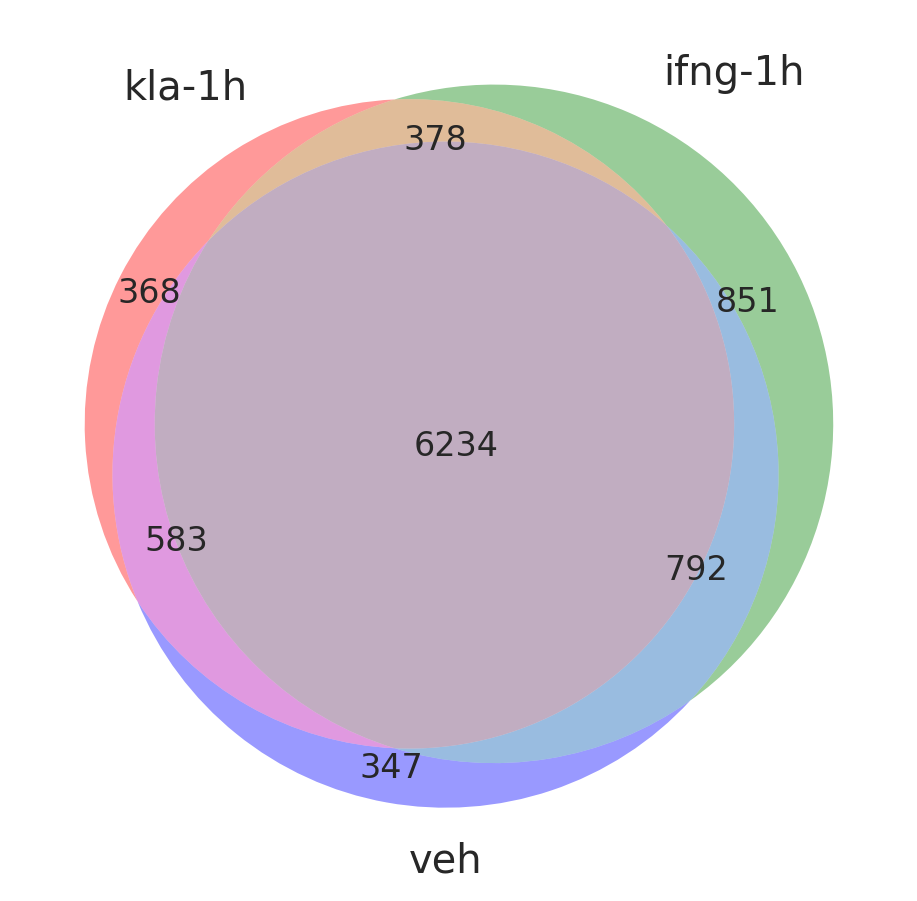

In [9]:
matplotlib_venn.venn3(id_set_list, labels)

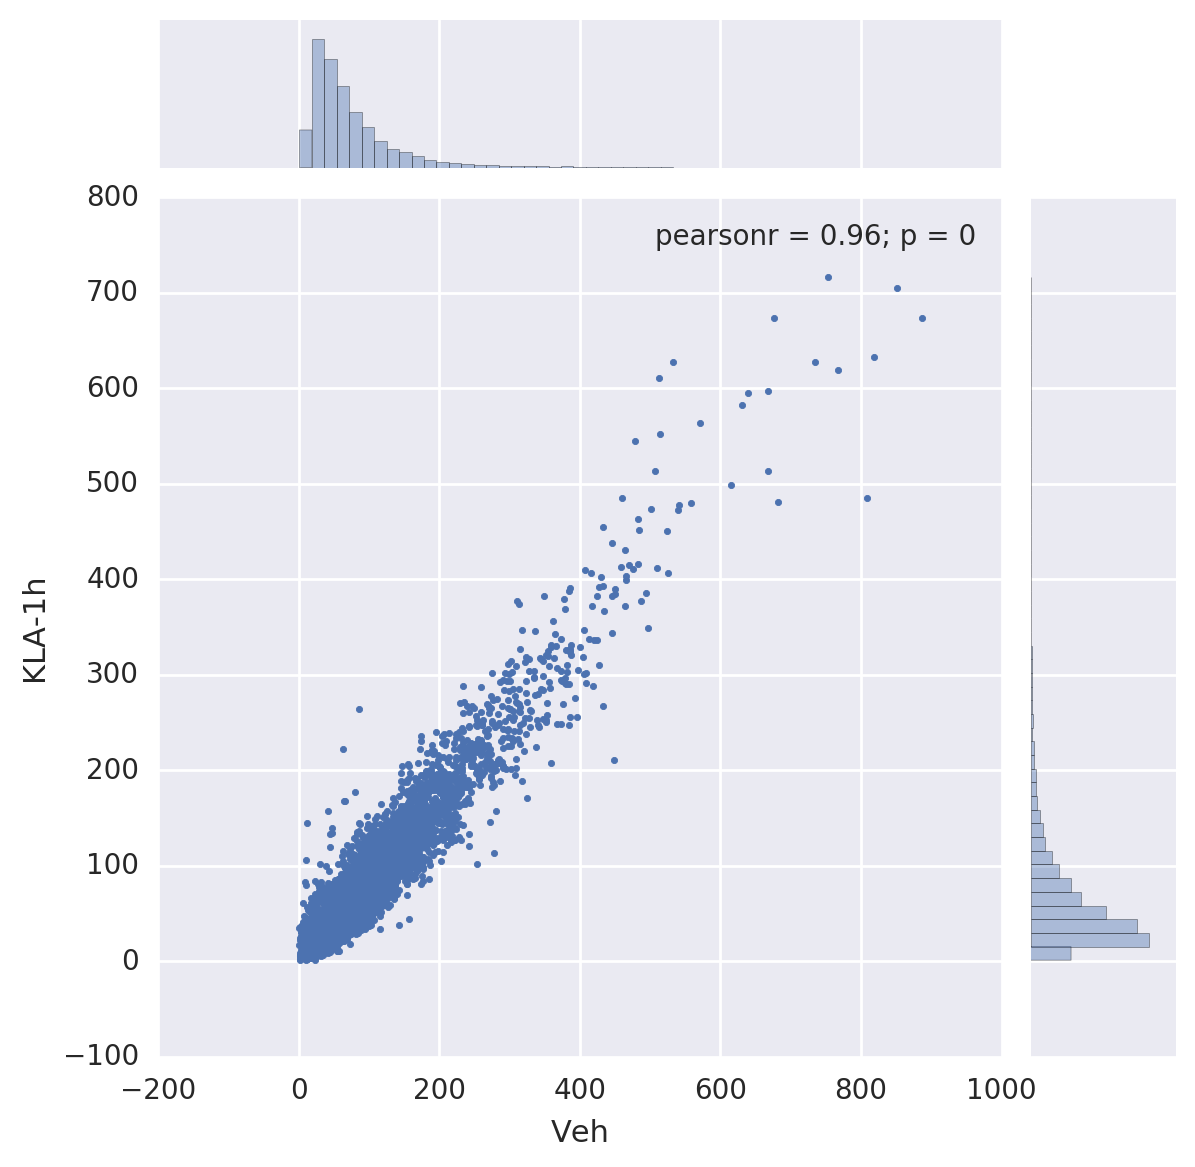

In [10]:
sns.jointplot(annotated_promoter_frame['Veh'], annotated_promoter_frame['KLA-1h'], s=5)

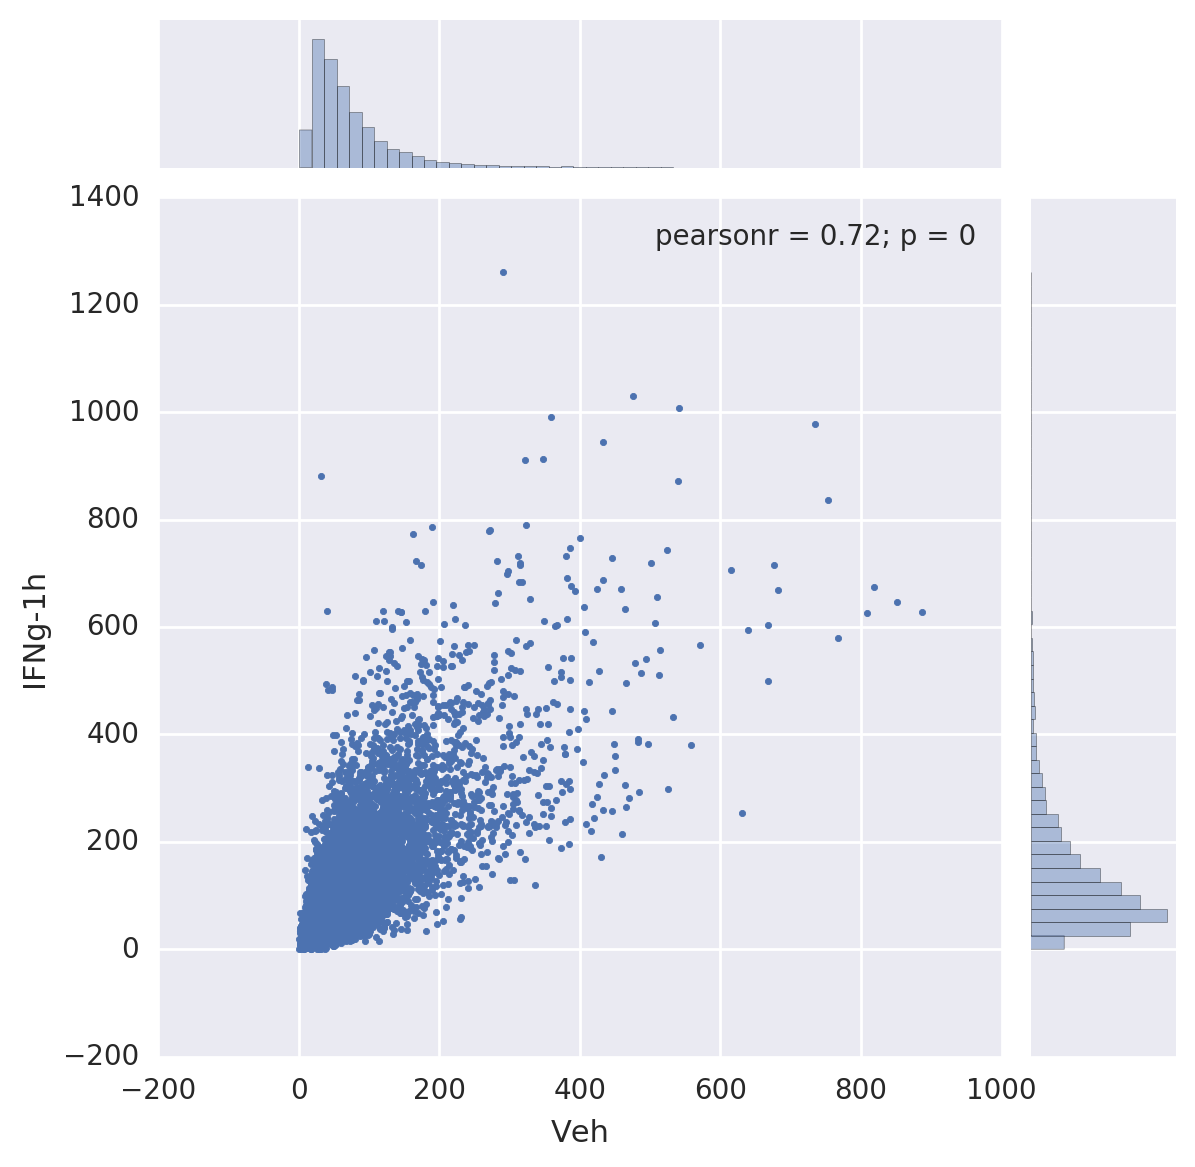

In [11]:
sns.jointplot(annotated_promoter_frame['Veh'], annotated_promoter_frame['IFNg-1h'], s=5)

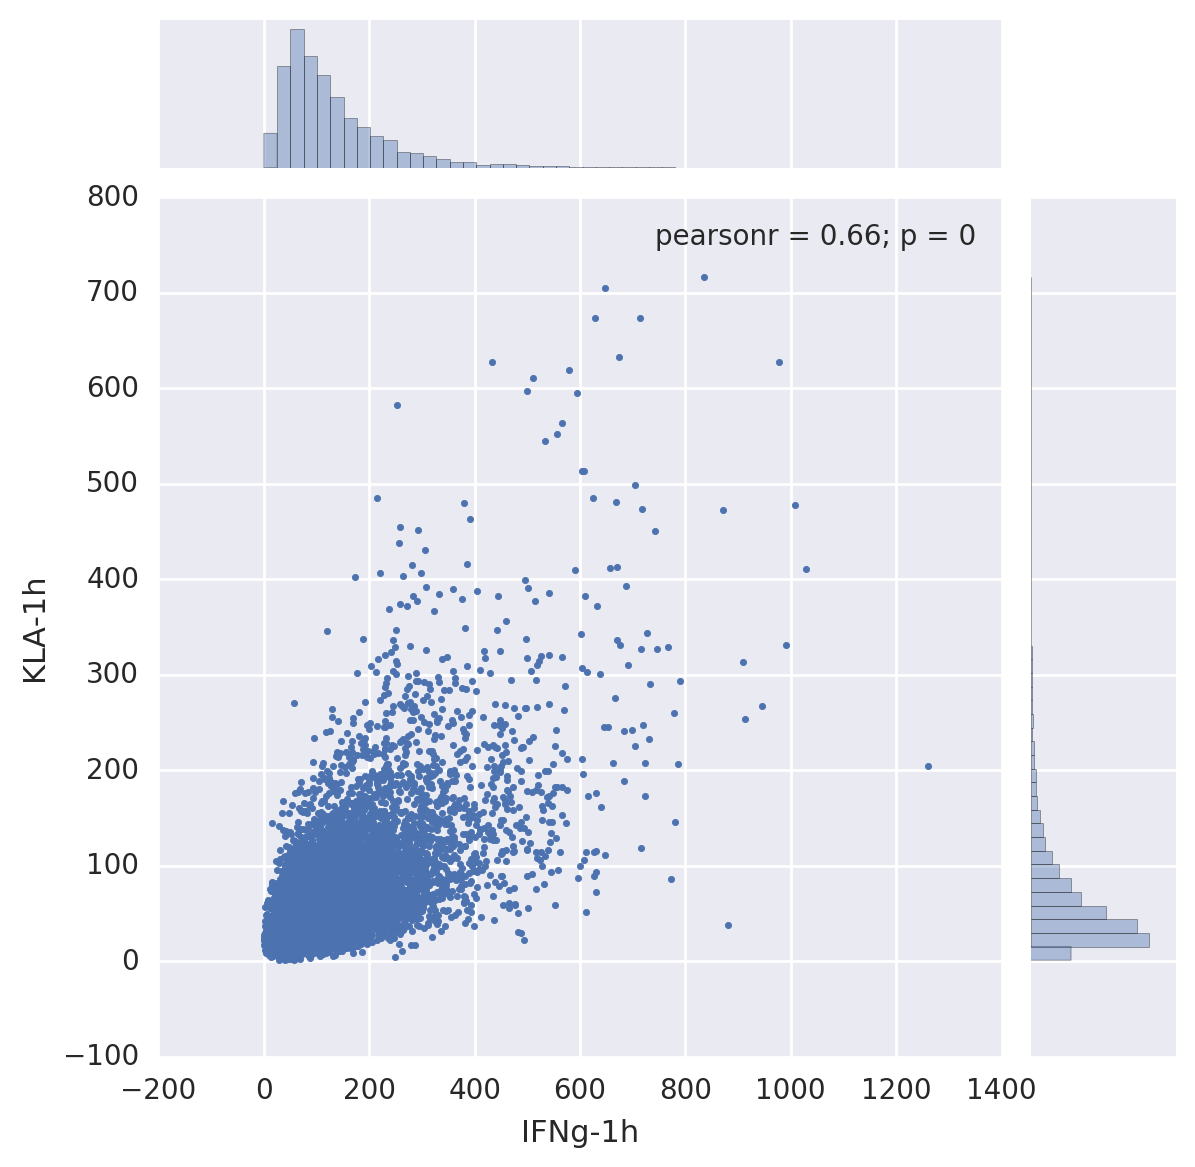

In [65]:
sns.jointplot(annotated_promoter_frame['IFNg-1h'], annotated_promoter_frame['KLA-1h'], s=5)

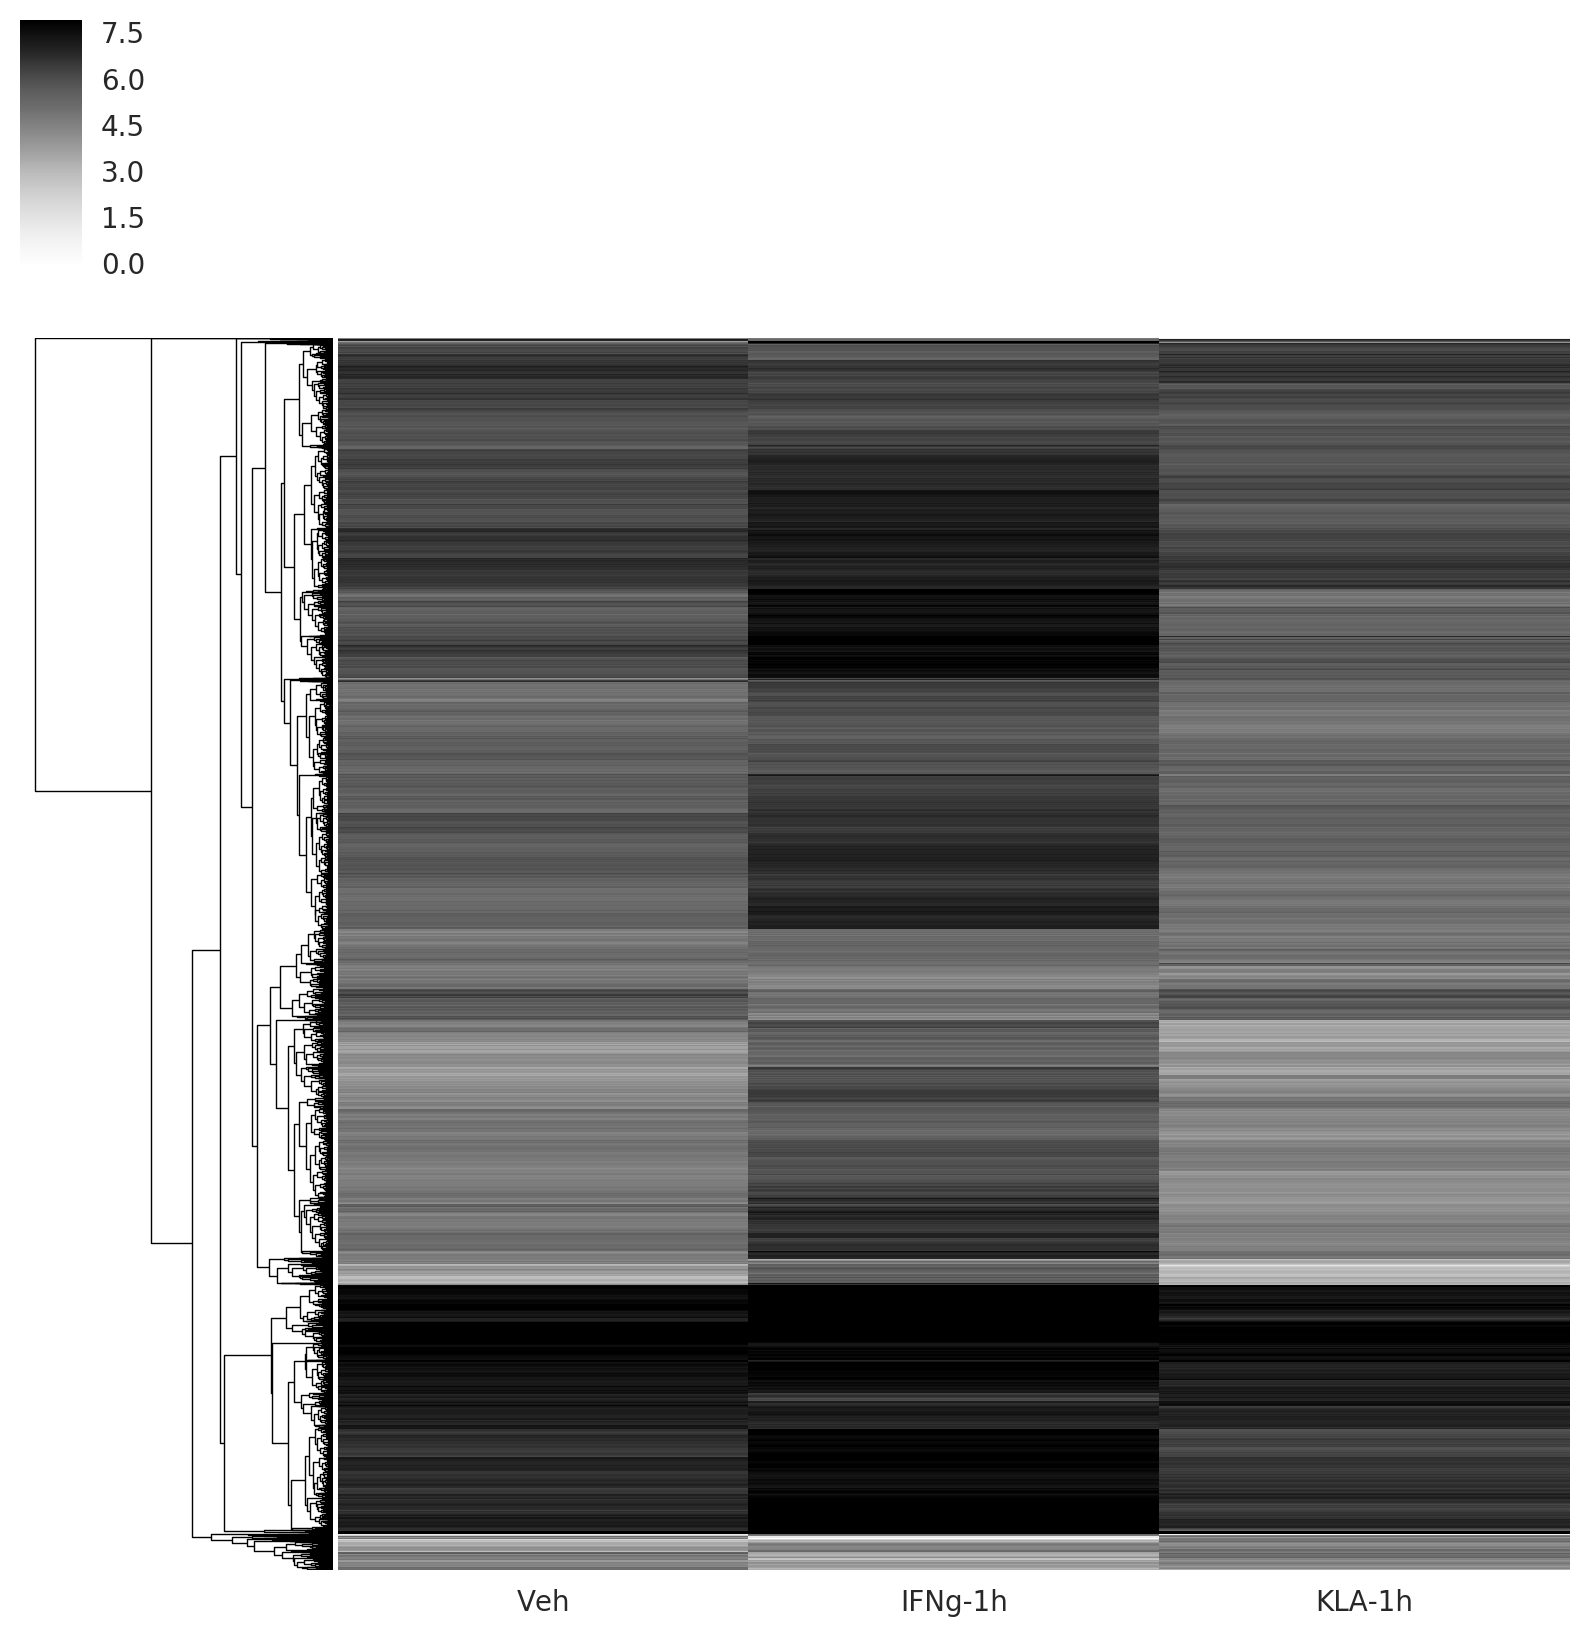

In [26]:
sns.clustermap(np.log2(annotated_promoter_frame.ix[:,-3:]+1), 
               col_cluster = False,
               yticklabels=False, 
               xticklabels=True,
               cmap='Greys',
               vmax=8)

In [15]:
ratios = (annotated_promoter_frame['KLA-1h'] + 1 )/(annotated_promoter_frame['IFNg-1h'] + 1)


## Read in Expression Data

In [34]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
columns[7] = 'gene'

columns = [x.lower() for x in columns]
diff_expression_frame.columns = columns

In [35]:
diff_expression_frame = diff_expression_frame.ix[:,['refseq', 'chr', 'start', 'end', 'gene'] + [x for x in diff_expression_frame.columns if 'vs.' in x]]
diff_expression_frame['gene'] = [x.split('|')[0] for x in diff_expression_frame['gene'].values]

In [100]:
rpkm_frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = rpkm_frame.columns.values
columns[0] = 'Refseq'
columns[7] = 'Gene'
rpkm_frame.columns = columns
rpkm_frame.index = rpkm_frame['Gene'].values
rpkm_frame['Gene'] = [x.split('|')[0] for x in rpkm_frame['Gene'].values]
rpkm_frame.drop('chr', axis=1, inplace=True)
rpkm_frame.drop('start', axis=1, inplace=True)
rpkm_frame.drop('end', axis=1, inplace=True)
rpkm_frame.drop('strand', axis=1, inplace=True)
rpkm_frame.drop('Length', axis=1, inplace=True)
rpkm_frame.drop('Copies', axis=1, inplace=True)

rpkm_mean_frame = rpkm_frame[['Refseq', 'Gene']]
for condition in ['Veh-1h', 'KLA-1h', 'IFNg-1h']:
    current_cols = [x for x in rpkm_frame.columns if condition in x]
    mean_vals = rpkm_frame[current_cols].mean(axis=1)
    rpkm_mean_frame[condition] = mean_vals
    

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


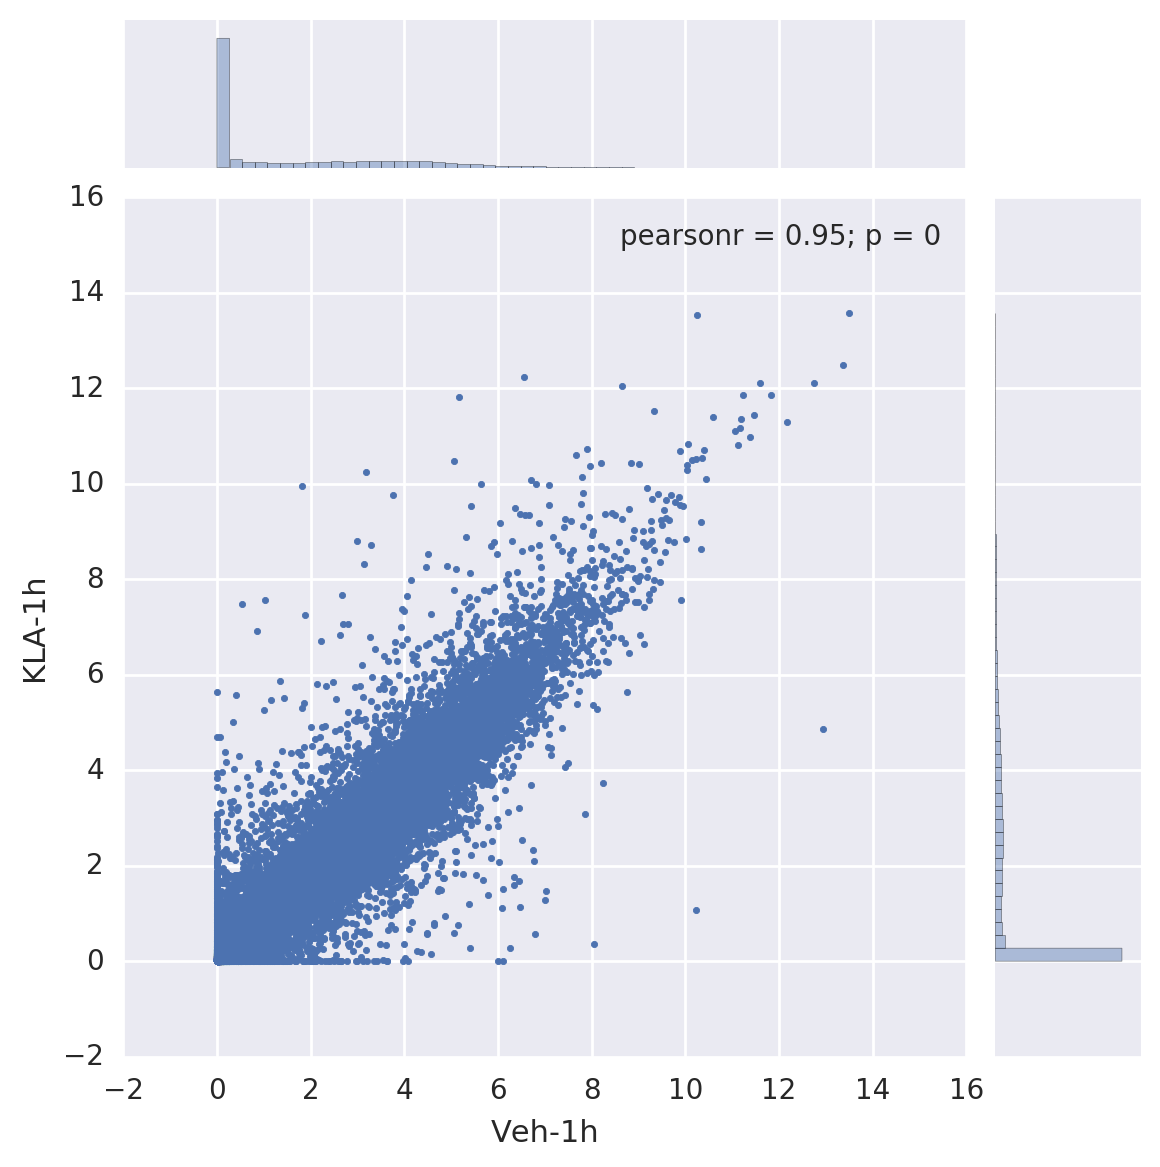

In [62]:
sns.jointplot(np.log2(rpkm_mean_frame['Veh-1h']+1),
              np.log2(rpkm_mean_frame['KLA-1h']+1),
              s=5)

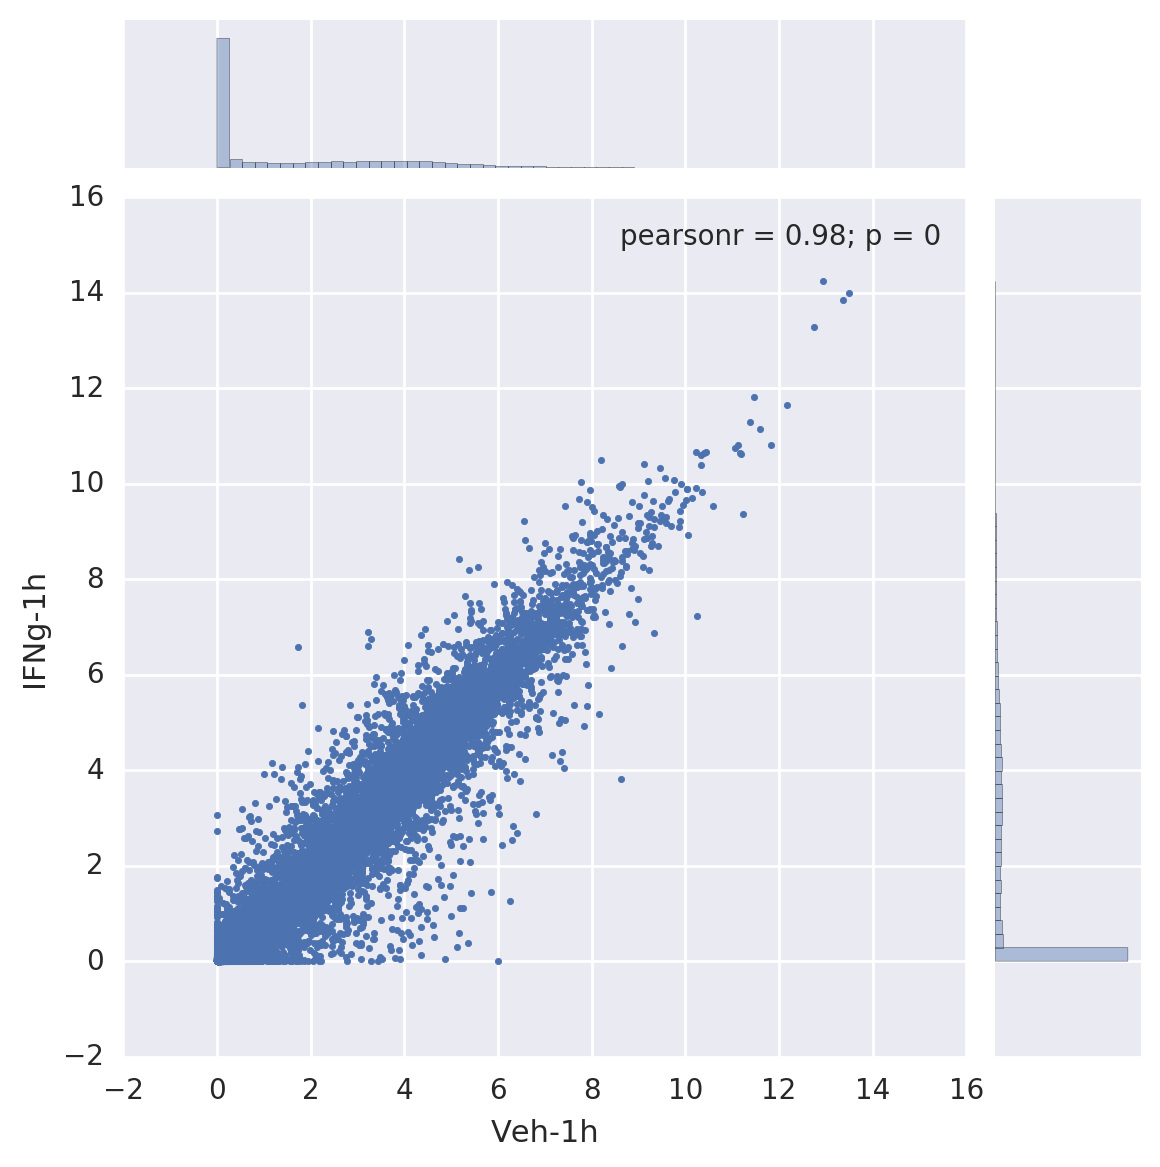

In [63]:
sns.jointplot(np.log2(rpkm_mean_frame['Veh-1h']+1),
              np.log2(rpkm_mean_frame['IFNg-1h']+1),
              s=5)

In [76]:
diff_expressed_genes = diff_expression_frame[(diff_expression_frame['veh-1h vs. ifng-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['veh-1h vs. kla-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['ifng-1h vs. kla-1h adj. p-value'] < 0.05)
                                            ]['gene'].values





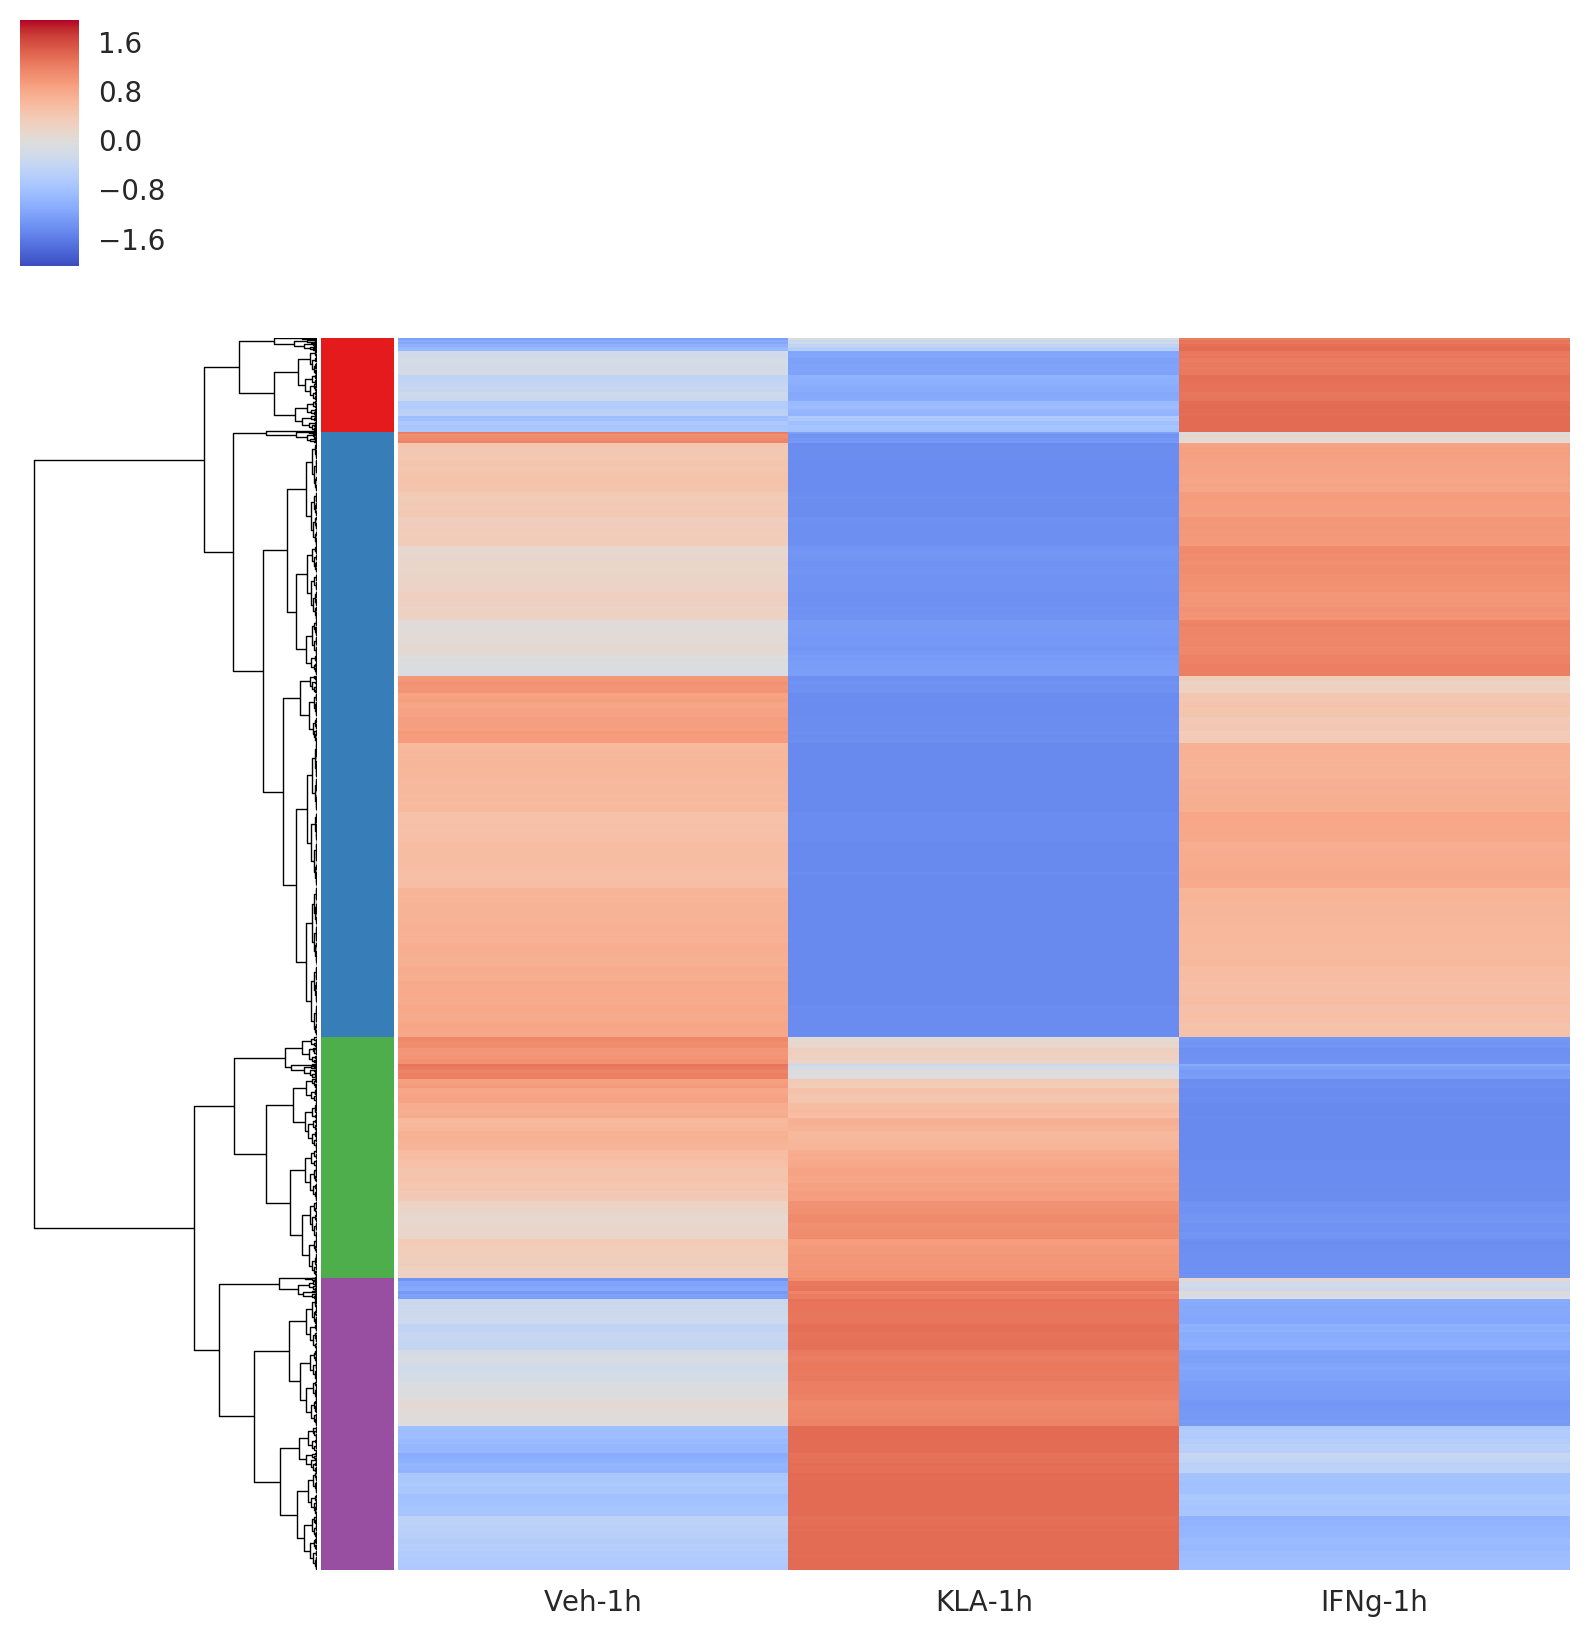

In [101]:
numRowClusters = 4
colorDict = dict(zip(range(numRowClusters),sns.color_palette("Set1")))

data = rpkm_mean_frame[(rpkm_mean_frame['Gene'].isin(diff_expressed_genes)) &
                (rpkm_mean_frame.ix[:,3:].max(axis=1) >= 4)].ix[:,2:]
# data = rpkm_mean_frame[(rpkm_mean_frame['Gene'].isin(diff_expressed_genes)) &
#                 (rpkm_mean_frame.ix[:,3:].max(axis=1) >= 4)].ix[:,['KLA-1h', 'IFNg-1h']]
zscores = np.log2(data+1).apply(scipy.stats.zscore, axis=1)
cg=sns.clustermap(zscores,
               yticklabels=False,
               col_cluster=False,
               row_cluster=True,
               vmin=-2,
               vmax=2,
               cmap='coolwarm'
              )
plt.close()
row_linkage = cg.dendrogram_row.linkage

row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")

row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(zscores.index))]
sns.clustermap(zscores, 
                row_linkage = row_linkage,
                row_colors = row_colors,
                yticklabels = False,
                col_cluster=False,
                vmin=-2,
                vmax=2,
                cmap='coolwarm'
)



## Identifying Signal Specific Syntax

In [106]:
gene_cluster_dict = dict(zip(zscores.index.values, row_flatCluster))
cluster_genes_dict = {x:[] for x in range(1,numRowClusters+1)}
for gene in gene_cluster_dict:
    cluster = gene_cluster_dict[gene] 
    cluster_genes_dict[cluster].append(gene)

In [125]:
def plot_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        color_dict = None,
                        symmetric_motifs = [],
                        algorithm_plot = False,
                       ):
    '''
    visualize a single sequence using the highest scoring nonoverlapping motifs
    '''
    motif_names = sorted(motif_score_dict.keys())
    seq_array = sequence_array_list[seq_index]
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.Graph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(motif_score_dict[motif][seq_index])))
        forward_scores = motif_score_dict[motif][seq_index]
        revcomp_scores = motif_score_rc_dict[motif][seq_index]

        # identify motif instances using score threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # figure out which edges to create
    edges_to_add = set()
    for pos in range(len(position_node_array)):
        nodes_at_pos = position_node_array[pos]
        # make sure edges are ordered alphabetically
        # so I don't have to deal with A-B and B-A
        nodes_at_pos.sort() 
        # generate proposed edges
        num_nodes = len(nodes_at_pos)
        for i in range(num_nodes - 1):
            for j in range(i+1, num_nodes):
                id_1 = nodes_at_pos[i]
                id_2 = nodes_at_pos[j]
                edges_to_add.add((id_1,id_2))
    seq_graph.add_edges_from(edges_to_add)

    # find best motif instances

    # loop through nodes and remove motif instances until there are no neighboring motif instances
    num_edges = seq_graph.number_of_edges()
    num_nodes = seq_graph.number_of_nodes()
    
    node_counts = [num_nodes]
    edge_counts = [num_edges]
    motif_instances =[]
    while num_edges > 0:
        # sort nodes by motif score
        sorted_nodes = sorted(seq_graph.nodes(data=True), key=lambda x: x[1]['score'], reverse=True)

        top_node = sorted_nodes[0]
        top_node_id = top_node[0]

        # save motif instance
        motif_instances.append(top_node)

        # remove node and neighbors from graph
        neighbors = seq_graph.neighbors(top_node_id)

        seq_graph.remove_node(top_node_id)
        seq_graph.remove_nodes_from(neighbors)

        num_edges = seq_graph.number_of_edges()
        num_nodes = seq_graph.number_of_nodes()

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)
        
#         print(num_edges, num_nodes)
        
    # create list representation of motifs
    sorted_motif_instances = sorted(motif_instances, key = lambda x:x[1]['start'])
   
    if algorithm_plot:
        with sns.axes_style('ticks'):
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ln1 = ax1.plot(list(range(len(node_counts))), 
                     node_counts, 
                     c='red',
                     label = 'Motif Instances')

            ln2 = ax2.plot(list(range(len(edge_counts))), 
                     edge_counts, 
                     c='blue',
                     label = 'Motif Overlaps')
        
            ax1.set_xlabel('# Motifs Selected')
            ax1.set_ylabel('# Motif Instances')
            ax2.set_ylabel('# Motif Overlaps')
            
            lns = ln1+ln2
            labs = [l.get_label() for l in lns]
            ax2.legend(lns, labs, loc=0)
            
    # visualize loci
    if color_dict == None:
        color_dict = dict(zip(motif_names,
                            sns.color_palette("hls", len(motif_names))
                            )
                        )
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16,2))
        for mi in sorted_motif_instances:
            name = mi[1]['name']
            start = mi[1]['start']
            end = mi[1]['end']
            score = mi[1]['score']
            orientation = mi[1]['orientation']

            midpoint = start + (end - start)/2

            color = color_dict[name]
            # plot positions
            if name in symmetric_motifs:
                plt.plot([start, end], [0,0], c=color)
            elif orientation == '+':
                plt.arrow(start, 0, end-start, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
            else:
                plt.arrow(end, 0, start-end, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
    #         plt.plot([start, end], [-1,-1], c=color)
            # plot motif score
            plt.plot([midpoint, midpoint], [0, score], c=color)
            plt.annotate(xy=(midpoint-3.75, 1.5), s=name, size=8, rotation =90, ha='left', va='bottom')
        plt.ylim(-1,14)
        plt.xlim(0,seq_size)
        plt.xlabel('Position')
        plt.ylabel('Motif Score')
        sns.despine()
    
    
    return sorted_motif_instances

In [130]:
id_sequence_array_dict = dict(zip(id_list, sequence_array_list))